In [1]:
%cd /sound-spaces

/sound-spaces


In [4]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


# os.chdir('/private/home/changanvr/Projects/ss-local')
dataset = 'gibson' # or replace with 'mp3d', one example for each dataset

backend_cfg = habitat_sim.SimulatorConfiguration()
backend_cfg.scene_id = "data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"
backend_cfg.scene_dataset_config_file = "data/scene_datasets/mp3d_example/mp3d.scene_dataset_config.json"
sim.pathfinder.load_nav_mesh("data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.navmesh")
# if dataset == 'mp3d':
# else:
#     backend_cfg.scene_id = "data/scene_datasets/gibson/Oyens.glb"
#     # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
#     backend_cfg.scene_dataset_config_file = "data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json"
# # set navmesh path for searching for navigable points
# if dataset == 'mp3d':
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/mp3d/UwV83HsGsw3/UwV83HsGsw3.navmesh"))
# else:
#     sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)


audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True
audio_sensor_spec.channelLayout.channelType = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 4
# audio sensor location set with respect to the agent
audio_sensor_spec.position = [0.0, 1.5, 0.0]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True
sim.add_sensor(audio_sensor_spec)

audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
audio_sensor.setAudioMaterialsJSON("data/mp3d_material_config.json")

[22:38:38:282339]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


In [5]:
# sampled navigable point is on the floor
source_pos = sim.pathfinder.get_random_navigable_point()
print('Sample source location: ', source_pos)

Sample source location:  [-4.457195    0.072447   -0.34131554]


In [6]:
audio_sensor.setAudioSourceTransform(source_pos + np.array([0, 1.5, 0])) # add 1.5m to the height calculation 
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()
new_state.position = np.array(source_pos + np.array([2, 0, 0]))
new_state.sensor_states = {}
agent.set_state(new_state, True)
# observations = sim.get_sensor_observations()
# when a category is not found in the material mapping file, the default acoustic material will be used.

In [7]:
ir = np.array(sim.get_sensor_observations()["audio_sensor"])
ir.shape

Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.


(4, 35903)

In [8]:
ir = np.array(audio_sensor.getIR())
ir.shape

(4, 35903)

In [9]:
def get_obj_data(o):
    return {k: getattr(o, k) for k in dir(o) if not k.startswith('__')}

In [10]:
spec=audio_sensor.specification()
get_obj_data(spec)

{'acousticsConfig': <habitat_sim._ext.habitat_sim_bindings.RLRAudioPropagationConfiguration at 0x7dc4884f0eb0>,
 'channelLayout': <habitat_sim._ext.habitat_sim_bindings.RLRAudioPropagationChannelLayout at 0x7dc4884f0ab0>,
 'enableMaterials': True,
 'is_visual_sensor_spec': <bound method PyCapsule.is_visual_sensor_spec of <habitat_sim._ext.habitat_sim_bindings.AudioSensorSpec object at 0x7dc488cff090>>,
 'noise_model': 'None',
 'noise_model_kwargs': {},
 'orientation': Vector(0, 0, 0),
 'outputDirectory': '/home/AudioSimulation',
 'position': Vector(0, 1.5, 0),
 'sensor_subtype': <SensorSubType.IMPULSERESPONSE: 5>,
 'sensor_type': <SensorType.AUDIO: 10>,
 'uuid': 'audio_sensor'}

In [11]:
get_obj_data(spec.acousticsConfig)

{'diffraction': True,
 'direct': True,
 'directSHOrder': 3,
 'dumpWaveFiles': False,
 'enableMaterials': True,
 'frequencyBands': 4,
 'globalVolume': 0.25,
 'indirect': True,
 'indirectRayCount': 5000,
 'indirectRayDepth': 200,
 'indirectSHOrder': 1,
 'irTime': 4.0,
 'maxDiffractionOrder': 10,
 'meshSimplification': False,
 'sampleRate': 48000,
 'sourceRayCount': 200,
 'sourceRayDepth': 10,
 'temporalCoherence': False,
 'threadCount': 1,
 'transmission': True,
 'unitScale': 1.0,
 'updateDt': 0.019999999552965164,
 'writeIrToFile': False}

In [12]:
get_obj_data(spec.channelLayout)

{'channelCount': 4,
 'channelType': <RLRAudioPropagationChannelLayoutType.Binaural: 3>}

In [13]:
# check if the direct sound is present (source is visibile from the listener)
audio_sensor.sourceIsVisible()

AttributeError: 'habitat_sim._ext.habitat_sim_bindings.AudioSensor' object has no attribute 'sourceIsVisible'

In [19]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
audio_sensor.getRayEfficiency()

AttributeError: 'habitat_sim._ext.habitat_sim_bindings.AudioSensor' object has no attribute 'getRayEfficiency'

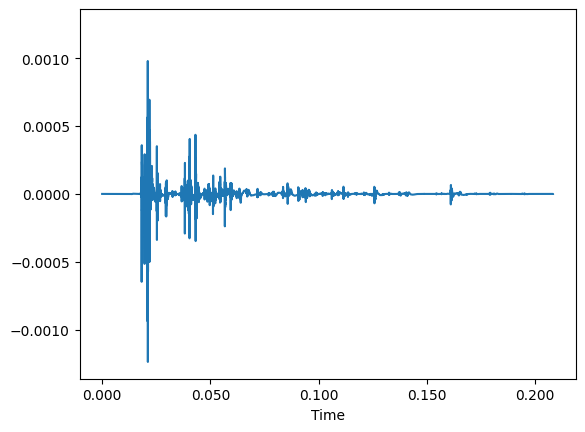

In [14]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython

waveshow(ir[0, :10000], sr=48000)
IPython.display.Audio(ir, rate=48000)

In [15]:
# one example for how to use IR data to get the reverberant speech
sr, vocal = wavfile.read('res/singing.wav')
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

48000 (233873,)


/tmp/ipykernel_50/3675352108.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, vocal = wavfile.read('res/singing.wav')


In [16]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

RT60 of the rendered IR is 0.2894 seconds


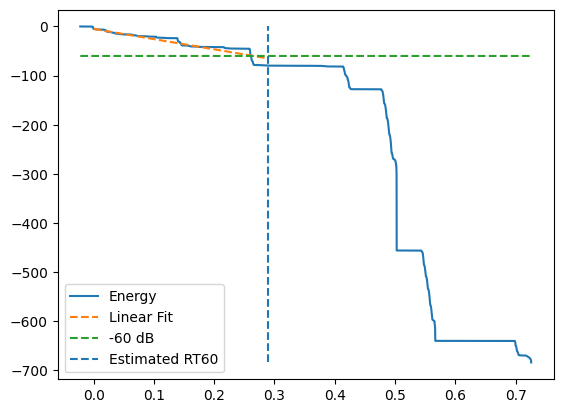

In [18]:
from pyroomacoustics.experimental.rt60 import measure_rt60

rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
print(f'RT60 of the rendered IR is {rt60:.4f} seconds')